# Bivariate analysis
This is a breaking moment when this analysis is narrowed down to a research question:
- **Can we predict canceled bookings?**

From now on, focus is on the categorical variable **is_canceled**, its relationship with other categories, as well as numerical variables.\
In this notebook you will also find analysis of relationships among continuous numerical variables.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
from matplotlib.backends.backend_pdf import PdfPages

df = pd.read_csv("../data/02.csv")
pd.set_option("display.max_columns", None)
cat = df[df.columns[df.nunique() < 5]]
num = df[df.columns[df.nunique() >= 5]]

# Categories
## Frequencies
From bookings that belong to a certain category, these are the ones where canceled bookings are in majority:
- booked_by_agent: 39%
- hotel_City: 42%
- meal_BB: 37%
- meal_FB: 60%
- market_segment_Groups: 61%
- distribution_channel_TA_TO: 41%
- reserved_room_type_A: 39%
- reserved_room_type_H: 41%
- deposit_type_Non_Refund: 99%
- customer_type_Transient: 41%

In [2]:
def crosstabs_with_highlights(cat):
    """
    Generates crosstabs for each categorical column in the DataFrame except 'is_canceled',
    with highlighted values where 'is_canceled' == 1 is the maximum percentage, and returns
    these crosstabs for further use or analysis.
    
    Parameters:
    cat (DataFrame): The DataFrame containing the categorical data.
    
    Returns:
    List[Styler]: A list of Pandas Styler objects, each representing a styled crosstab.
    """
    
    # Define a function to highlight the cell (1, 1) if its value is greater than the cell (1, 0)
    def highlight_max_canceled_1(s):
        if s[1] > s[0]:
            return ["", "background-color: darkred; color: white"]
        return ["", ""]
    
    # List all columns in the cat DataFrame except 'is_canceled'
    columns_to_compare = [col for col in cat.columns if col != "is_canceled"]

    # Initialize list to store crosstab Styler objects
    crosstab_results = []
    
    # Create and display crosstabs with highlighted specific values
    for idx, column in enumerate(columns_to_compare, 1):
        # Calculate the crosstab and normalize by column values to percentage
        crosstab = pd.crosstab(cat["is_canceled"], cat[column], normalize="columns") * 100
        
        # Apply styling to highlight the maximum values where 'is_canceled' == 1
        styled_crosstab = crosstab.style.apply(highlight_max_canceled_1, axis=1, subset=pd.IndexSlice[1, :]).format("{:.0f}%")
        
        # Store the styled crosstab in the list
        crosstab_results.append(styled_crosstab)
        
        # Optionally, display each styled crosstab (can comment out if not needed)
        display(styled_crosstab)
        print("-" * 40)  # Use print to properly display the divider in text

    return crosstab_results

# Usage
crosstabs_highlighted = crosstabs_with_highlights(cat)
crosstabs_highlighted

is_repeated_guest,0,1
is_canceled,,
0,62%,85%
1,38%,15%


----------------------------------------


booked_by_company,0,1
is_canceled,,
0,62%,83%
1,38%,17%


----------------------------------------


booked_by_agent,0,1
is_canceled,,
0,75%,61%
1,25%,39%


----------------------------------------


hotel_City,0,1
is_canceled,,
0,72%,58%
1,28%,42%


----------------------------------------


hotel_Resort,0,1
is_canceled,,
0,58%,72%
1,42%,28%


----------------------------------------


meal_BB,0,1
is_canceled,,
0,64%,63%
1,36%,37%


----------------------------------------


meal_FB,0,1
is_canceled,,
0,63%,40%
1,37%,60%


----------------------------------------


meal_HB,0,1
is_canceled,,
0,63%,66%
1,37%,34%


----------------------------------------


meal_No_meal,0,1
is_canceled,,
0,63%,64%
1,37%,36%


----------------------------------------


market_segment_Aviation,0,1
is_canceled,,
0,63%,78%
1,37%,22%


----------------------------------------


market_segment_Complementary,0,1
is_canceled,,
0,63%,88%
1,37%,12%


----------------------------------------


market_segment_Corporate,0,1
is_canceled,,
0,62%,81%
1,38%,19%


----------------------------------------


market_segment_Direct,0,1
is_canceled,,
0,60%,85%
1,40%,15%


----------------------------------------


market_segment_Groups,0,1
is_canceled,,
0,68%,39%
1,32%,61%


----------------------------------------


market_segment_Offline_TA_TO,0,1
is_canceled,,
0,62%,66%
1,38%,34%


----------------------------------------


market_segment_Online_TA,0,1
is_canceled,,
0,63%,63%
1,37%,37%


----------------------------------------


distribution_channel_Corporate,0,1
is_canceled,,
0,62%,78%
1,38%,22%


----------------------------------------


distribution_channel_Direct,0,1
is_canceled,,
0,60%,83%
1,40%,17%


----------------------------------------


distribution_channel_GDS,0,1
is_canceled,,
0,63%,81%
1,37%,19%


----------------------------------------


distribution_channel_TA_TO,0,1
is_canceled,,
0,81%,59%
1,19%,41%


----------------------------------------


reserved_room_type_A,0,1
is_canceled,,
0,68%,61%
1,32%,39%


----------------------------------------


reserved_room_type_B,0,1
is_canceled,,
0,63%,67%
1,37%,33%


----------------------------------------


reserved_room_type_C,0,1
is_canceled,,
0,63%,67%
1,37%,33%


----------------------------------------


reserved_room_type_D,0,1
is_canceled,,
0,62%,68%
1,38%,32%


----------------------------------------


reserved_room_type_E,0,1
is_canceled,,
0,62%,71%
1,38%,29%


----------------------------------------


reserved_room_type_F,0,1
is_canceled,,
0,63%,70%
1,37%,30%


----------------------------------------


reserved_room_type_G,0,1
is_canceled,,
0,63%,64%
1,37%,36%


----------------------------------------


reserved_room_type_H,0,1
is_canceled,,
0,63%,59%
1,37%,41%


----------------------------------------


reserved_room_type_L,0,1
is_canceled,,
0,63%,67%
1,37%,33%


----------------------------------------


deposit_type_No_Deposit,0,1
is_canceled,,
0,1%,72%
1,99%,28%


----------------------------------------


deposit_type_Non_Refund,0,1
is_canceled,,
0,72%,1%
1,28%,99%


----------------------------------------


deposit_type_Refundable,0,1
is_canceled,,
0,63%,78%
1,37%,22%


----------------------------------------


customer_type_Contract,0,1
is_canceled,,
0,63%,69%
1,37%,31%


----------------------------------------


customer_type_Group,0,1
is_canceled,,
0,63%,90%
1,37%,10%


----------------------------------------


customer_type_Transient,0,1
is_canceled,,
0,74%,59%
1,26%,41%


----------------------------------------


customer_type_Transient-Party,0,1
is_canceled,,
0,60%,75%
1,40%,25%


----------------------------------------


## Independence test
- **is_canceled** category has been tested for independence from all the other categories, starting with the null hypothesis:
  - H0: there is no significiant association between **is_canceled** and another category; they are independent variables,
  - at the significance level (alpha) is set at 0.05.
-  According to **chi2 test**, there is a **significant association** between **is_canceled** and almost all the other categories.\
However, measured by the **Cramér's V**, majority (25/35) associations are **weak**, 9 moderate, and the only significant and strong associations are between:
1. **is_canceled** and **deposit_type_No_Deposit**
2. **is_canceled** and **deposit_type_Non_Refund**

Time-permitting, we could eventually return to these tests, bin some numerical variables such as **lead_time** to convert them into categories, and test their association with **is_canceled**.

In [3]:
def chi2_cramersv(cat):
    """
    Performs Chi-Square tests of independence for each categorical column in the DataFrame,
    excluding 'is_canceled'. It also calculates Cramer's V for the strength of association.
    
    Parameters:
    cat (DataFrame): The DataFrame containing the categorical data.
    
    Returns:
    DataFrame: A DataFrame containing the Chi-Square test results and Cramer's V analysis.
    """
    # List all columns in the DataFrame except 'is_canceled'
    columns_to_compare = [col for col in cat.columns if col != "is_canceled"]

    # Initialize an empty list to store the results
    chi2_results = []

    # Perform a Chi-Square test of independence for each column
    for column in columns_to_compare:
        crosstab = pd.crosstab(cat["is_canceled"], cat[column])
        chi2, p, dof, expected = chi2_contingency(crosstab)
        
        # Total sample size
        n = crosstab.sum().sum()  
        
        # Calculate Cramer's V
        cramer_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
        
        # Diagnosis based on p-value
        p_diagnosis = "Significant" if p < 0.05 else "Not Significant"
        
        # Diagnosis based on Cramer's V value
        if cramer_v < 0.1:
            v_diagnosis = "Weak"
        elif cramer_v < 0.3:
            v_diagnosis = "Moderate"
        else:
            v_diagnosis = "Strong"
        
        # Append the results to the list
        chi2_results.append({
            "Variable Name": column,
            "Chi2 Value": chi2,
            "P-value": p,
            "Cramer's V": cramer_v,
            "P-value Diagnosis": p_diagnosis,
            "Cramer's V Diagnosis": v_diagnosis
        })

    # Convert the results to a DataFrame for nicer display
    return pd.DataFrame(chi2_results)

# Use:
chi2_cramersv_results = chi2_cramersv(cat)
chi2_cramersv_results

,Variable Name,Chi2 Value,P-value,Cramer's V,P-value Diagnosis,Cramer's V Diagnosis
0,is_repeated_guest,834.926290,1.376122e-183,0.083690,Significant,Weak
1,booked_by_company,1183.649330,2.181605e-259,0.099647,Significant,Weak
2,booked_by_agent,1246.240775,5.445596e-273,0.102247,Significant,Moderate
3,hotel_City,2238.609968,0.000000e+00,0.137038,Significant,Moderate
4,hotel_Resort,2238.609968,0.000000e+00,0.137038,Significant,Moderate
5,meal_BB,19.353470,1.086217e-05,0.012742,Significant,Weak
6,meal_FB,178.427777,1.068337e-40,0.038689,Significant,Weak
7,meal_HB,47.884784,4.520161e-12,0.020042,Significant,Weak
8,meal_No_meal,5.078587,2.422310e-02,0.006527,Significant,Weak
9,market_segment_Aviation,21.911258,2.855538e-06,0.013558,Significant,Weak


# Cancelations vs numerical variables
## Distribution comparison
- **Boxplots show that canceled bookings have longer lead time**; the further ahead someonne makes a booking - it's more likely that they'll cancel it.
- Variable **previous_cancelations** has a noticeable number of outliers for canceled bookings, indicating that guests who have previously canceled are more likely to cancel again.
- Variable **previous_bookings_not_canceled** has a wider spread and higher outliers, suggesting that guests with a history of not canceling tend to continue not canceling their bookings.
- No other factors seem to be predictive of whether a booking is likely to be canceled.

All box plots have been successfully saved to the PDF.


[<Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>]

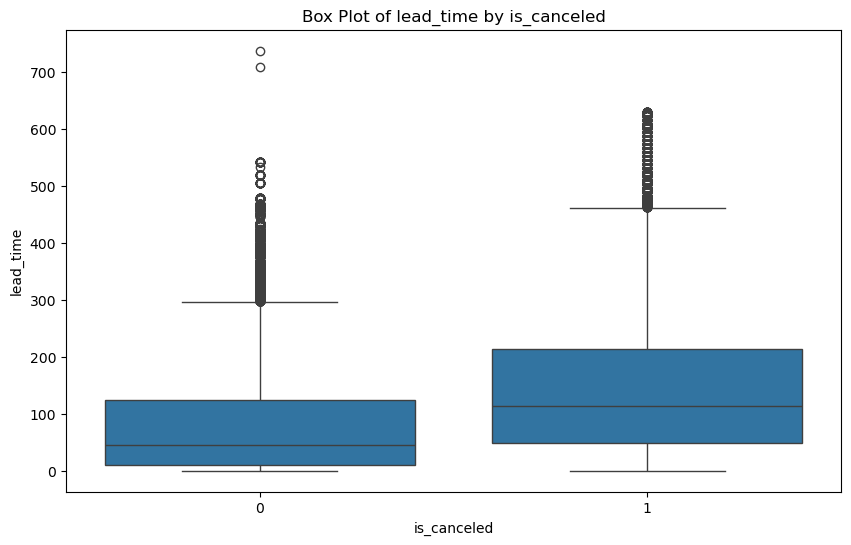

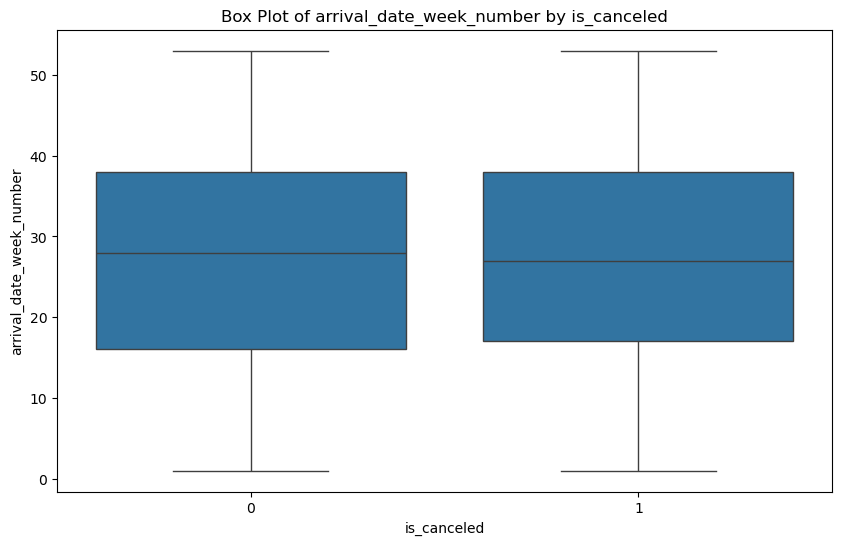

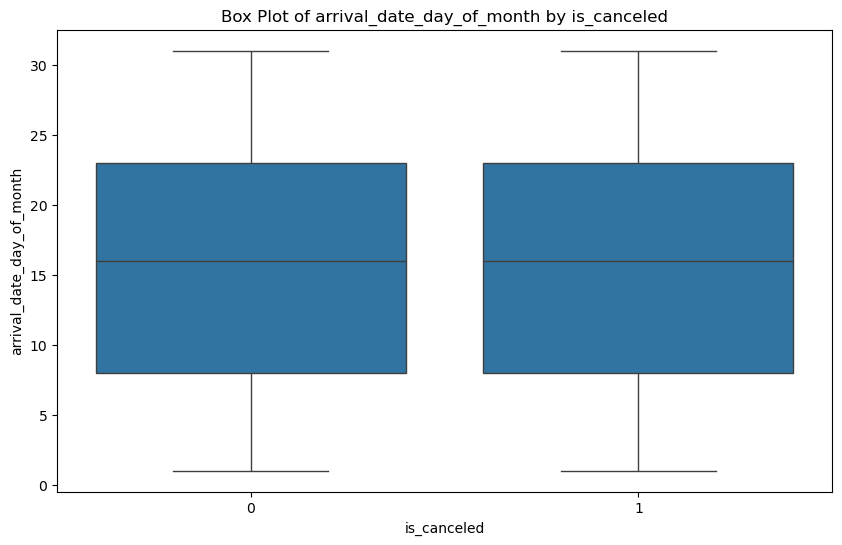

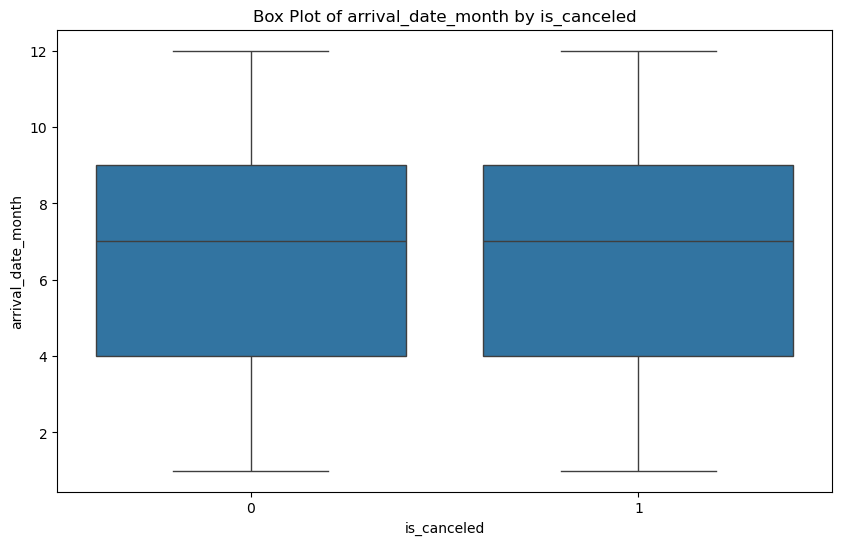

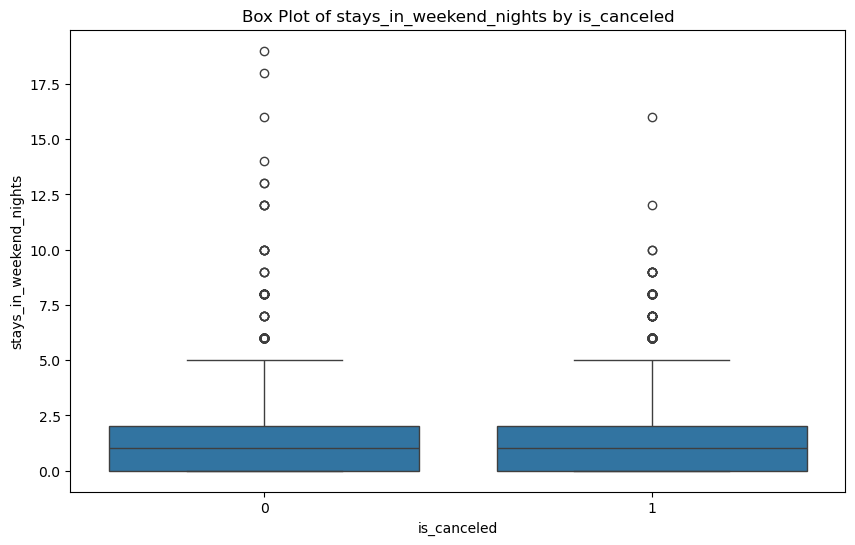

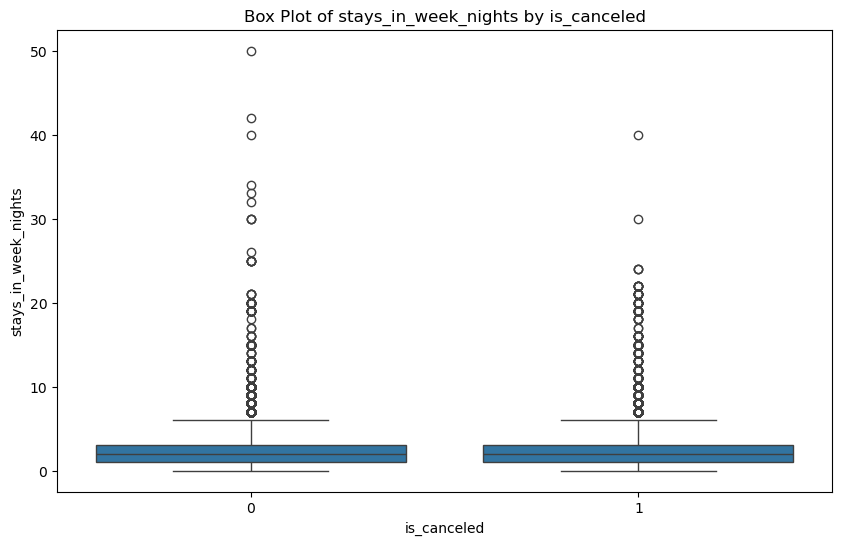

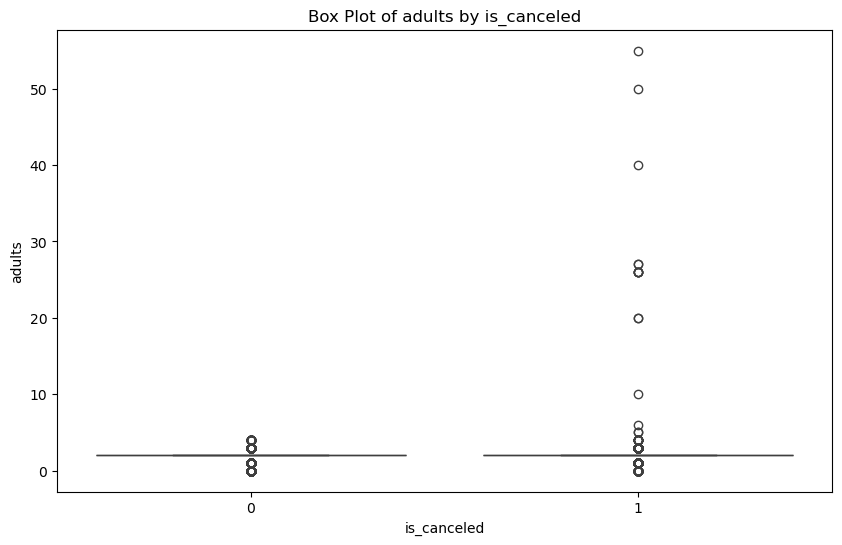

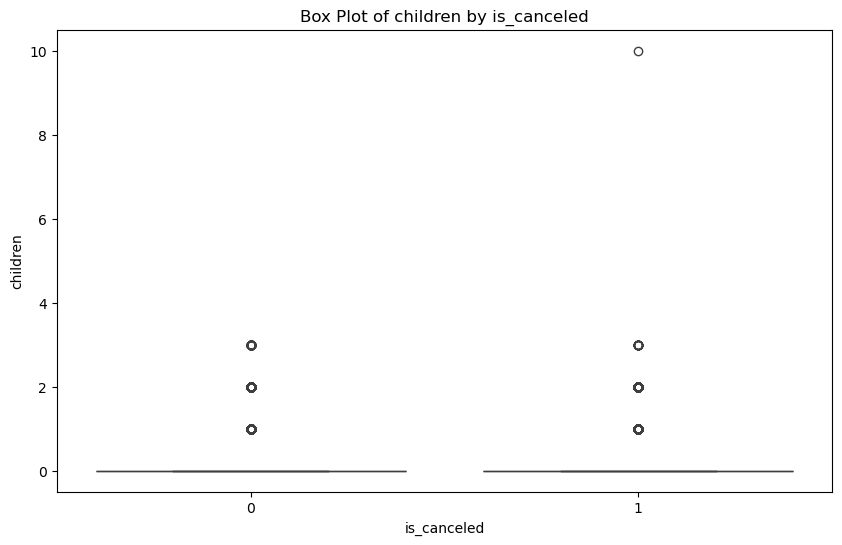

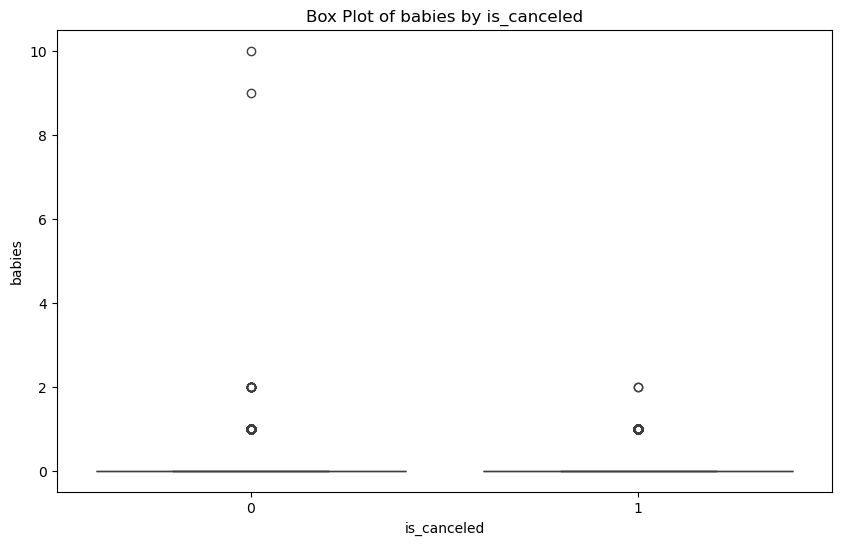

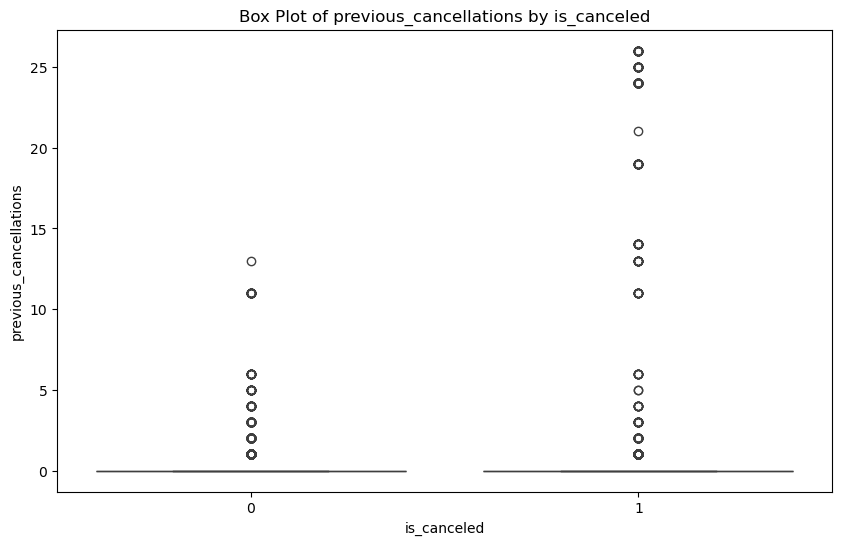

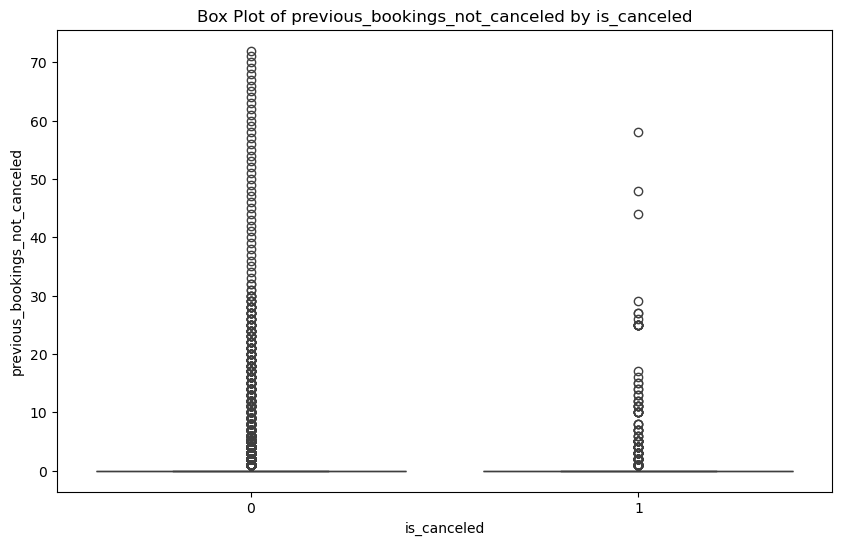

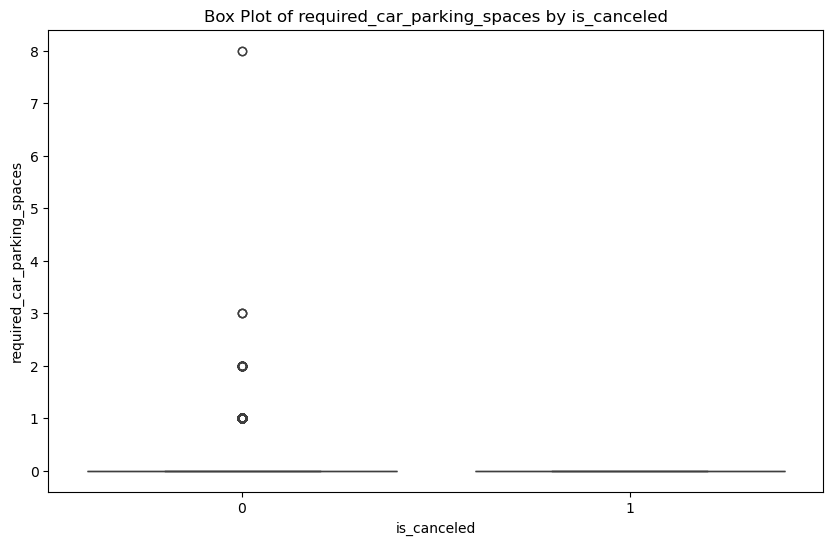

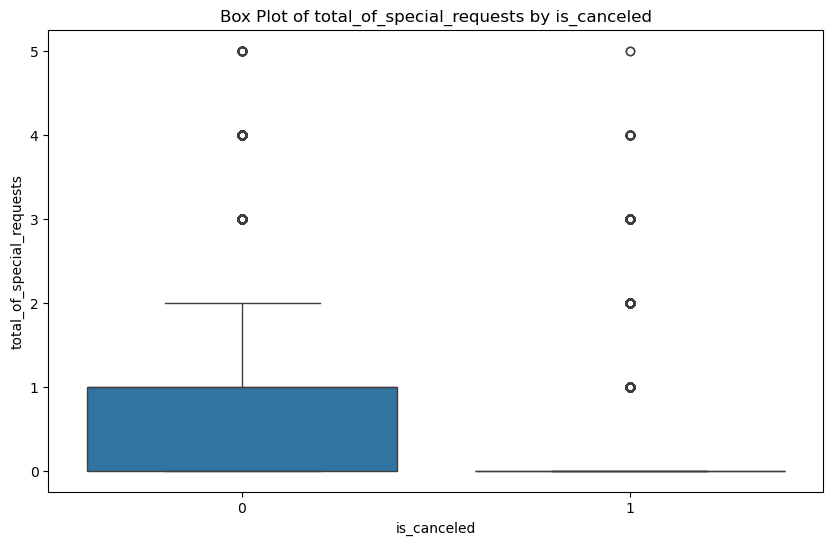

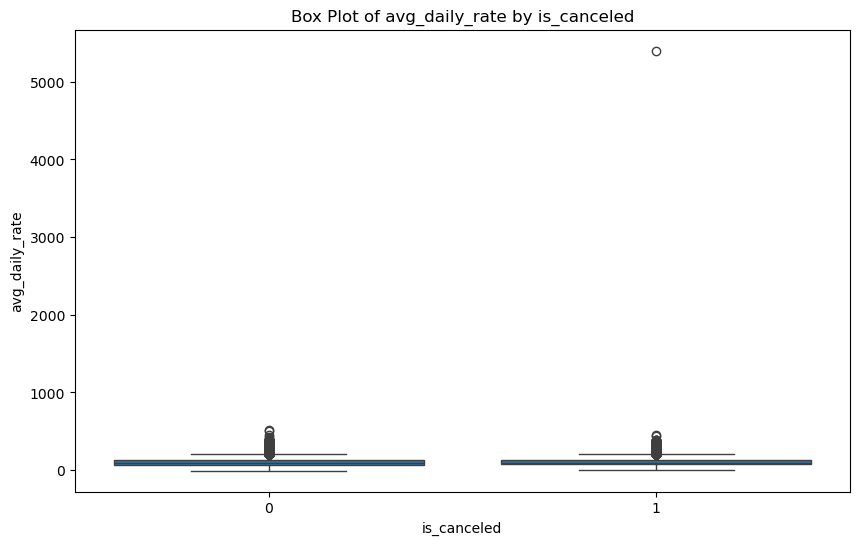

In [4]:
def generate_box_plots(num, is_canceled):
    """
    Generates box plots for each numerical column in the DataFrame, comparing distributions 
    between the 'is_canceled' categories, saves the plots to a PDF file, and returns the list of box plot figures.
    
    Parameters:
    num (DataFrame): The DataFrame containing the numerical data to plot.
    is_canceled (Series): A Pandas Series indicating whether each entry in 'data' was canceled.
    
    Returns:
    list: A list of matplotlib figure objects for each box plot created during the plotting process.
    """
    # Define the path to save the PDF in the 'plots' folder
    pdf_path = "../plots/boxplots.pdf"
    
    # Initialize a list to store the box plot figure objects
    boxplot_figures = []

    # Loop through each numerical column in 'data' and create a box plot compared to 'is_canceled'
    with PdfPages(pdf_path) as pdf:
        for column in num.columns:
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.boxplot(x=is_canceled, y=num[column], ax=ax)
            ax.set_title(f"Box Plot of {column} by is_canceled")
            ax.set_xlabel("is_canceled")  # Adding labels for clarity
            ax.set_ylabel(column)        # Adding labels for clarity
            pdf.savefig(fig)  # Save the current figure into the pdf
            boxplot_figures.append(fig)  # Append the figure object to the list
    
    print("All box plots have been successfully saved to the PDF.")
    
    return boxplot_figures

# Usage
boxplot_figures = generate_box_plots(num, df["is_canceled"]);
boxplot_figures

# Numerical variables
## Linearity test
**Visual check for linearity** between every possible pair of continuous variables was done by creating individual scatterplots.\
To avoid memory overload because of a high number of plots (91 in this case), it's recommended to not display the plots.\
If you run the code below, upon observing the message "All plots have been successfully saved to the PDF.", you can find the scattrplots saved in a single .pdf file titled **scatter_plots**, located in the folder titled **plots**.

The sccaterplots show **no relationships** among continuous variables.\

In [6]:
def generate_scatter_plots(data, df):
    """
    Generates scatter plots for each pair of numerical columns in the DataFrame, coloring by the 'is_canceled' status. 
    Saves the plots to a PDF file. This function is useful for examining relationships between pairs of features with respect to cancellation status.

    Parameters:
    data (DataFrame): The DataFrame containing the numerical data to plot.
    df (DataFrame): The main DataFrame that includes the 'is_canceled' column used for coloring the points in scatter plots.
    """
    # Define the path to save the PDF in the 'plots' folder
    pdf_path = "../plots/scatter_plots.pdf"
    # Set verbosity level
    verbose = 1

    # Total number of plots
    total_plots = len(data.columns) * (len(data.columns) - 1) // 2
    current_plot = 0

    # Iterate over each pair of columns to create a scatter plot
    with PdfPages(pdf_path) as pdf:
        for i in range(len(data.columns)):
            for j in range(i + 1, len(data.columns)):
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x=data[data.columns[i]], y=data[data.columns[j]], hue=df["is_canceled"])
                plt.title(f"Scatter Plot of {data.columns[i]} vs {data.columns[j]}")
                plt.xlabel(data.columns[i])
                plt.ylabel(data.columns[j])
                plt.legend(title="is_canceled")
                pdf.savefig()  # Save the current figure into the pdf
                plt.close()  # Close the figure to free up memory
                
                # Increment and print the progress if verbose and current_plot is a multiple of 5
                current_plot += 1
                if verbose and current_plot % 5 == 0:
                    print(f"Completed {current_plot} of {total_plots} plots.")

        if verbose:
            print("All plots have been successfully saved to the PDF.")

# Usage
generate_scatter_plots(num, df)

Completed 5 of 91 plots.
Completed 10 of 91 plots.
Completed 15 of 91 plots.
Completed 20 of 91 plots.
Completed 25 of 91 plots.
Completed 30 of 91 plots.
Completed 35 of 91 plots.
Completed 40 of 91 plots.
Completed 45 of 91 plots.
Completed 50 of 91 plots.
Completed 55 of 91 plots.
Completed 60 of 91 plots.
Completed 65 of 91 plots.
Completed 70 of 91 plots.
Completed 75 of 91 plots.
Completed 80 of 91 plots.
Completed 85 of 91 plots.
Completed 90 of 91 plots.
All plots have been successfully saved to the PDF.


## Correlations
Due to the lack of normality and linearity, choice is either to transform data or go on with non-parametric tests.\
Considering the time constraint, the current goal is to deliver a minimum viable product/project, so we'll first work with data as-is, **with non-parametric tests**.\
Time-permitting, we could eventually return to this point, transform data, and run parametric tests.

**Correlation matrix and correlation heatmap** confirm what scatterplots had shown: very weak relationships between the continuous numerical variables.\
The only strong correlation is between arrival_date_week_number and arrival_date_month.\
However, this is expected, logical relationship because months are composed of weeks.

In [7]:
# Calculate correlation matrix for numerical continuous columns
correlation_matrix_num = num.corr(method="spearman")

# Extract upper triangle of correlation matrix (excluding the diagonal)
upper_triangle = correlation_matrix_num.where(np.triu(np.ones(correlation_matrix_num.shape), k=1).astype(bool))

# Stack the upper triangle to get a Series of correlation values
correlation_values_num = upper_triangle.stack().sort_values(ascending=False)

# Convert correlation values to a DataFrame
correlation_df_num = correlation_values_num.reset_index()
correlation_df_num.columns = ["category_1", "category_2", "correlation"]

# Display the DataFrame
display(correlation_df_num.head(), correlation_df_num.tail())

,category_1,category_2,correlation
0,arrival_date_week_number,arrival_date_month,0.995450
1,lead_time,stays_in_week_nights,0.295775
2,adults,avg_daily_rate,0.276111
3,children,avg_daily_rate,0.265392
4,stays_in_weekend_nights,stays_in_week_nights,0.236609


,category_1,category_2,correlation
86,lead_time,required_car_parking_spaces,-0.141931
87,previous_bookings_not_canceled,avg_daily_rate,-0.143040
88,previous_cancellations,avg_daily_rate,-0.150486
89,lead_time,previous_bookings_not_canceled,-0.188944
90,adults,previous_bookings_not_canceled,-0.210485


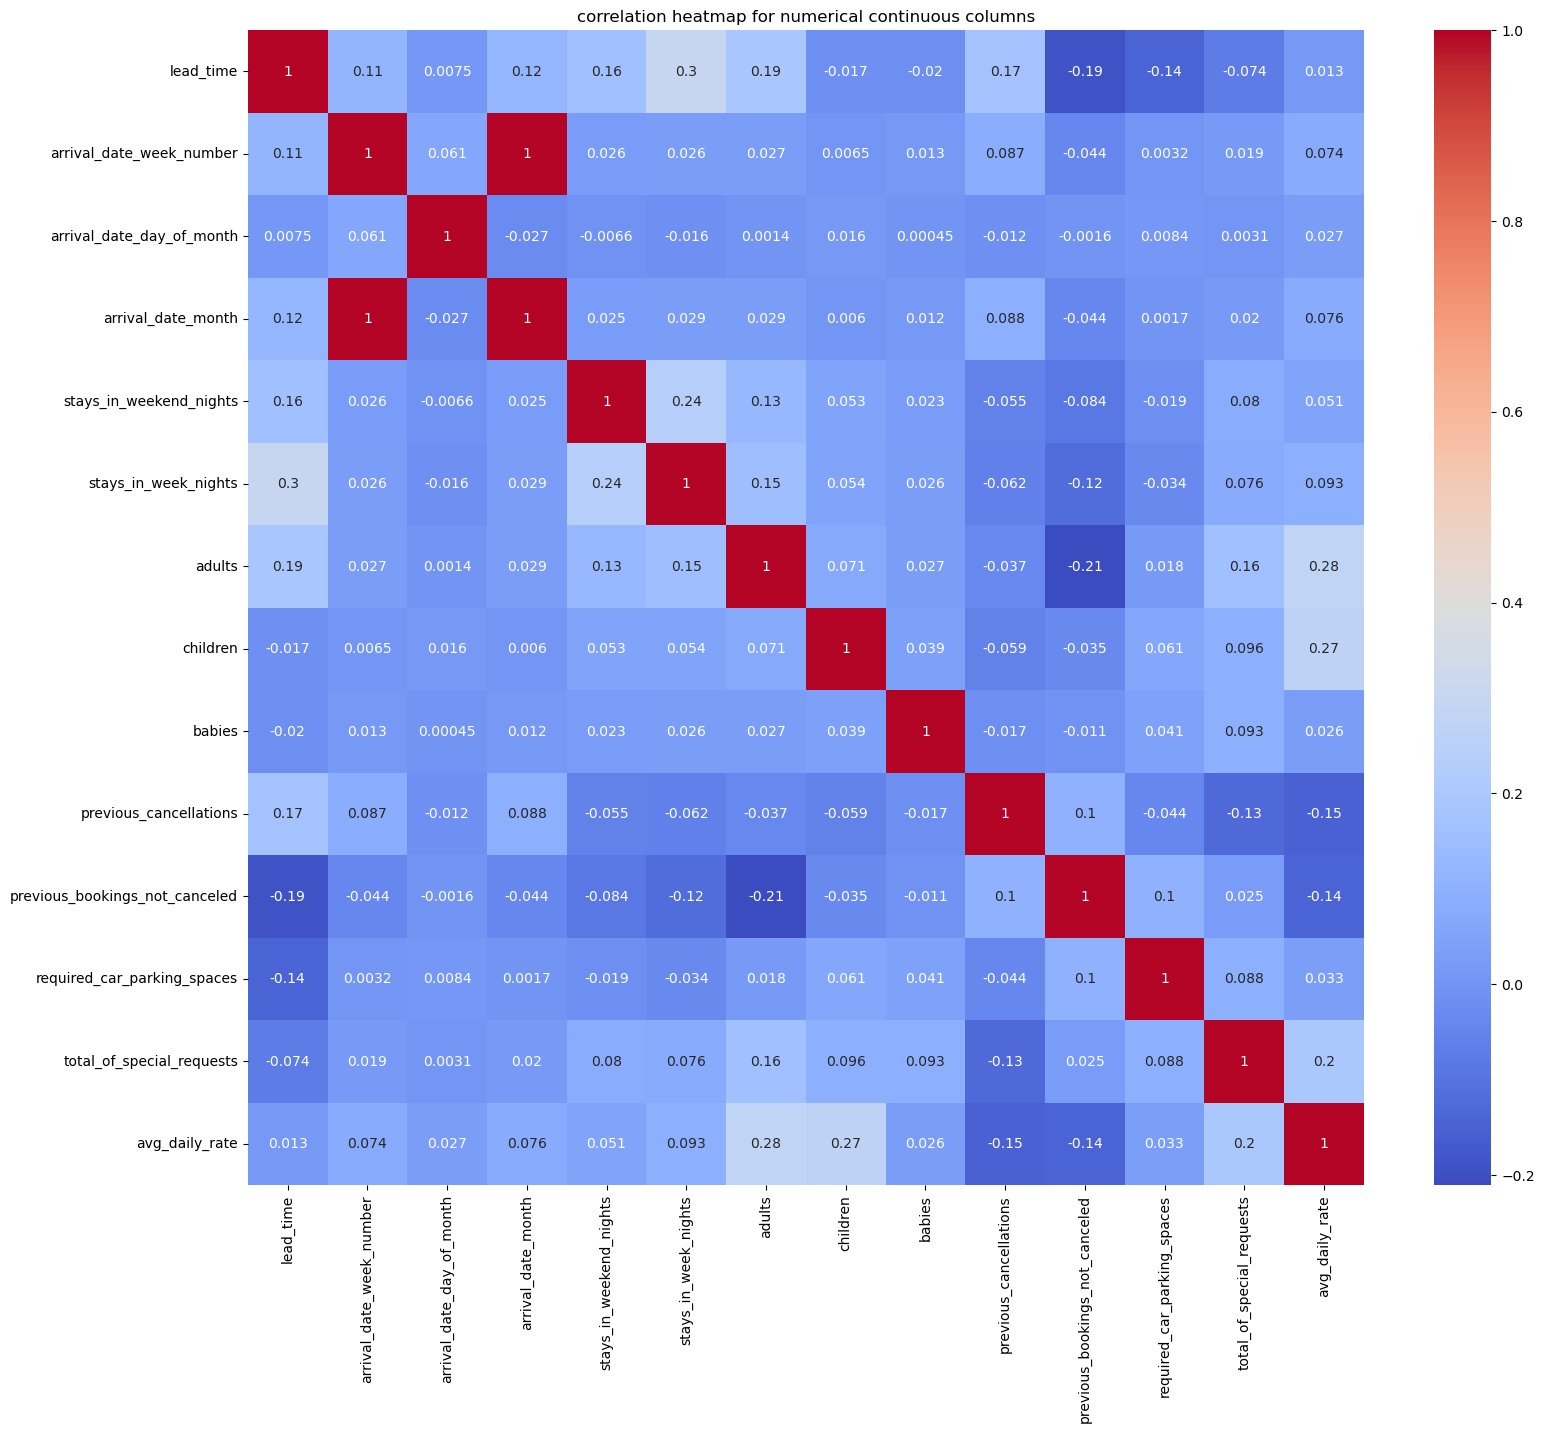

In [8]:
# Create a heatmap for numerical continuous columns
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix_num, annot=True, annot_kws={"size": 10}, cmap="coolwarm")
plt.title("correlation heatmap for numerical continuous columns")
plt.show()

# Hypothesis testing
## Cancelations vs numerical variables
**Mann-Whitney U test** was used to compare the distribution of each numerical continuous variable between two independent samples: bookings categorized as **not canceled** and **canceled**.\
All the resulting p-values are below the threshold of 0.05, **indicating statistically significant differences between the two groups for all tested variables**.

In [9]:
def mann_whitney_u_tests(df, numerical_columns, target_column="is_canceled"):
    """
    Performs the Mann-Whitney U test for each numerical column in the DataFrame against a categorical target column.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    numerical_columns (list): List of column names of numerical data to test.
    target_column (str): The name of the binary target column to test against.
    
    Returns:
    a DataFrame with Mann-Whitney U test results including U statistic and p-values.
    """
    # Dictionary to store test statistics and p-values
    results = {}
    
    # Perform Mann-Whitney U test for each numerical variable against the categorical variable
    for column in numerical_columns:
        if column != target_column:  # Ensure we're not testing the target against itself
            # Split the data into two groups based on the categorical variable
            group1 = df[df[target_column] == 0][column]
            group2 = df[df[target_column] == 1][column]
            
            # Perform the test
            u_stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
            
            # Store the U statistic and p-value in the dictionary
            results[column] = {"U_stat": u_stat, "p_value": p_value}
    
    # Convert the results to a DataFrame for nicer display
    mann_whitney_results = pd.DataFrame.from_dict(results, orient="index")
    
    return mann_whitney_results

# Use:
mann_whitney_results = mann_whitney_u_tests(df, num)
mann_whitney_results

,U_stat,p_value
lead_time,1.030475e+09,0.000000e+00
arrival_date_week_number,1.642240e+09,7.598423e-03
arrival_date_day_of_month,1.669270e+09,4.111464e-02
arrival_date_month,1.637645e+09,4.944553e-04
stays_in_weekend_nights,1.665134e+09,1.589411e-01
stays_in_week_nights,1.577405e+09,1.977334e-46
adults,1.559638e+09,1.068649e-113
children,1.660213e+09,3.014979e-01
babies,1.667866e+09,1.646685e-32
previous_cancellations,1.447211e+09,0.000000e+00


# Summary

- univariate analysis:
  - numerical variables:
    - **normality, visual check** (histogram): 11/14 variables show **non-normal distribution**, right-skewed, most data concentrated on the lower end
    - **normality test** (shapiro-wilk, kolmogorov-smirnov): **non-normal distribution** (all the p-values < 0.05)
    - **shape of distribution**:
      - skewness: 8/14 variables exhibit **highly assymetric data**, 6/14 moderately assymetric
      - kurtosis: 9/14 variables have **heavy tails or outliers**, 5/14 light tails or lack of outliers.
        
---
- bivariate analysis:
  - categorical variables:
    - **independence test** (chi2): **significant association between is_canceled and almost all the other categories**
    - **strength of association** (cramer's v): weak for majority (25/35) of categories, moderate for 9/35.
  - category (is_canceled) vs numerical variables:
    - **distribution comparison** (boxplot):
      - canceled bookings have longer lead time
      - previous cancelations indicate future cancelations
      - absence of previous cancelations indicate future adherence to the booking
  - numerical variables:
    - **linearity** (scatterplot): **no linear relationship** among continuous variables
    - **correlation**: **very weak relationships**.

---
- hypothesis testing:
  - **statistically significant differences** between canceled and non-canceled bookings for all numerical variables.
---
Next: notebook_04_machine_learning_01_intro